In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
# load frogge files
# start from the 12th frame

img_root = './custom-data-dump/stand/seq-1/'
files = os.listdir(img_root)
files.sort()
# files = files[11:]
files = [f for f in files if 'jpg' in f]

images = []
for fl in files : 
    im = cv2.imread(img_root + '/' + fl)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    images.append(im)
images = np.array(images)

image_color = cv2.imread(img_root + '/' + files[0])
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)

In [5]:
def per_plane_shadow_edge_estimation2(I, offset_row, offset_col) :
        
    I_max = np.max(I,0)
    I_min = np.min(I,0)
    I_shadow = (I_max + I_min) / 2
    diff_image = np.zeros(I.shape)
    shadow_time = np.zeros(I_shadow.shape)
    for t in range(I.shape[0]) : 
        diff_image[t] = I[t] - I_shadow
    line_params = np.zeros((3,I.shape[0]))
    pts_arr = []
    for t in range(diff_image.shape[0]) : 
        pts = []
        for i in range(diff_image.shape[1]):
            cur_pt = []
            cur_neg_count = 0
            for j in range(diff_image.shape[2]-1):
                
                if diff_image[t][i][j] < 0 : cur_neg_count += 1
                else : cur_neg_count = 0
                    
                if diff_image[t][i][j+1] >= 0 and diff_image[t][i][j] < 0 and cur_neg_count >= 25:
#                     pts.append([i+offset_row,j+offset_col,1])
                    cur_pt = [i+offset_row,j+offset_col,1]
                    break
            if cur_pt != [] : pts.append(cur_pt)
        if len(pts) == 0 : break 
        pts = np.array(pts)
        _,_,vh = np.linalg.svd(pts)
        line_params[:,t] = vh[:,-1]
        pts_arr.append(pts)

    pts_arr = np.array(pts_arr)
    return line_params, pts_arr


def per_pixel_shadow_time_estimate2(I) :
        
    I_max = np.max(I,0)
    I_min = np.min(I,0)
    I_shadow = (I_max + I_min) / 2
    diff_image = np.zeros(I.shape)
    shadow_time = np.zeros(I_shadow.shape)
    shadow_time_plot = np.zeros(I_shadow.shape)
    for t in range(I.shape[0]) : 
        diff_image[t] = I[t] - I_shadow
        
    bucket_size = diff_image.shape[0] / 32
    
    for i in range(diff_image.shape[1]):
        for j in range(diff_image.shape[2]):
            diff = -np.inf
            for t in range(diff_image.shape[0]-1):
                if(diff_image[t+1][i][j]-diff_image[t][i][j] > diff):
                    shadow_time[i][j] = t
                    shadow_time_plot[i][j] = t // bucket_size
                    diff = diff_image[t+1][i][j]-diff_image[t][i][j]
                    
    shadow_time[I_max - I_min < 15] = 0
    shadow_time_plot[I_max - I_min < 15] = 0
    
    return shadow_time, shadow_time_plot
    
    
# horizontal planar bounds
# plt.imshow(images[0,670:,200:820])
# vertical planar bounds
# plt.imshow(images[0,0:300,220:780])
I_hor_start_row, I_hor_end_row = 850, 1000 #last is not inclusive
I_hor_start_col, I_hor_end_col = 475, 1200 #last is not inclusive
I_hor_start_frame, I_hor_end_frame = 25, 71

I_ver_start_row, I_ver_end_row = 100, 330 #last is not inclusive
I_ver_start_col, I_ver_end_col = 475, 1200 #last is not inclusive
I_ver_start_frame, I_ver_end_frame = 25, 71


I_horizontal = images[I_hor_start_frame:I_hor_end_frame,
                      I_hor_start_row:I_hor_end_row,
                      I_hor_start_col:I_hor_end_col]

I_vertical = images[I_ver_start_frame:I_ver_end_frame,
                    I_ver_start_row:I_ver_end_row,
                    I_ver_start_col:I_ver_end_col]

line_params_horizontal, pts_hor = per_plane_shadow_edge_estimation2(I_horizontal/255, I_hor_start_row,I_hor_start_col)
line_params_vertical, pts_ver = per_plane_shadow_edge_estimation2(I_vertical/255, I_ver_start_row, I_ver_start_col)
# pts_ver, pts_hor = pts_ver[7:55], pts_hor[7:55] # for mug-seq1
shadow_time, shadow_time_plot = per_pixel_shadow_time_estimate2(images)

# for vertical points selection, 70 and -20
# for horizontal points selection, 10 and -10

/tmp/ipykernel_101699/1480845928.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pts_arr = np.array(pts_arr)


<IPython.core.display.Javascript object>


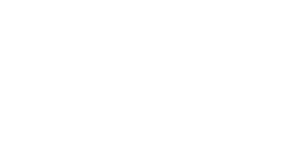

In [6]:
%matplotlib notebook
plt.imshow(shadow_time_plot, cmap='jet')

In [7]:
### INTRINSIC AND EXTRINSIC CALIBRATION
from src.cp_hw6 import pixel2ray
# load intrinsic and extrinsic params
intrinsics = np.load('custom-data-dump/calib-dec11/intrinsic_calib.npz')
extrinsics = np.load('custom-data-dump/stand/seq-1/extrinsic_calib.npz')
R_h,t_h = extrinsics['rmat_h'], extrinsics['tvec_h']
R_v,t_v = extrinsics['rmat_v'], extrinsics['tvec_v']
K = intrinsics['mtx']
distortion = intrinsics['dist']

In [8]:
def ray_plane_intersection(line_pt_plane, r_plane, plane_pt, plane_normal) : 
    
    ndotr = np.dot(r_plane, plane_normal)
    if ndotr == 0 : return None # ray and plane are parallel (won't happen in our case)
    
    w = line_pt_plane - plane_pt
    si = -np.dot(w,plane_normal) / ndotr
    Psi = w + si * r_plane + plane_pt
    
    return Psi

def get_3dpt_from_2dpt(p1,p2, R, t) : 
    
    p = np.array([p1,p2]).astype('float64')
    r = pixel2ray(p, K, distortion) # in camera coordinates
    r = r.squeeze().T # to get 3 * N
    r_plane = R.T @ (r) # 3d rays in plane coordinates
#     r_plane[:,0], r_plane[:,1] = r_plane[:,0] / np.linalg.norm(r_plane[:,0]), r_plane[:,1] / np.linalg.norm(r_plane[:,1]) 
    line_pt = np.array([0,0,0]).reshape((3,1))
    line_pt_plane = R.T @ (line_pt - t) # pt on ray line in plane coords
    line_pt_plane = line_pt_plane.squeeze()
    
    plane_pt = np.array([0,0,0]).reshape((3)) # pt on plane in plane coords
    plane_normal = np.array([0,0,1]).reshape((3)) # plane normal, plane coords
    
    P1_plane = ray_plane_intersection(line_pt_plane, r_plane[:,0], plane_pt, plane_normal)
    P2_plane = ray_plane_intersection(line_pt_plane, r_plane[:,1], plane_pt, plane_normal)
    
    P1_plane = P1_plane.reshape((3,1))
    P2_plane = P2_plane.reshape((3,1))

    P1_cam = R @ P1_plane + t
    P2_cam = R @ P2_plane + t
    
    return P1_cam, P2_cam
    

<IPython.core.display.Javascript object>


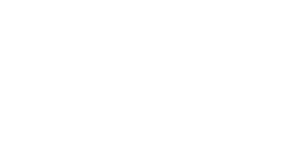

In [9]:
# collecting 3D points (Calibrating shadow lines)

P1_array, P2_array = [], []

for t in range(pts_hor.shape[0]) :
    p1 = pts_hor[t][1][:-1][::-1] # flipping x and y
    p2 = pts_hor[t][-1][:-1][::-1]
    P1, P2 = get_3dpt_from_2dpt(p1, p2, R_h, t_h)
    P1_array.append(P1)
    P2_array.append(P2)

P1_array = np.array(P1_array).squeeze()
P2_array = np.array(P2_array).squeeze()


P3_array, P4_array = [], []

for t in range(pts_ver.shape[0]) :
    p3 = pts_ver[t][1][:-1][::-1]
    p4 = pts_ver[t][-1][:-1][::-1]
    P3, P4 = get_3dpt_from_2dpt(p3, p4, R_v, t_v)
    P3_array.append(P3)
    P4_array.append(P4)

P3_array = np.array(P3_array).squeeze()
P4_array = np.array(P4_array).squeeze()

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P1_array[:,0],P1_array[:,1],P1_array[:,2], c='r')
ax.scatter(P2_array[:,0],P2_array[:,1],P2_array[:,2], c='r')
ax.scatter(P3_array[:,0],P3_array[:,1],P3_array[:,2], c='g')
ax.scatter(P4_array[:,0],P4_array[:,1],P4_array[:,2], c='b')

In [10]:
def get_shadow_plane(P1, P2, P3, P4) : 
    
    n = np.cross((P2-P1), (P4-P3))
    n_norm = n / np.linalg.norm(n)
    
    return P1, n_norm

def get_3d_point_on_shadow_plane(p, S) :
    
    p = np.array([p,p]).astype('float64')
    r = pixel2ray(p, K, distortion) # in camera coordinates
    r = r.squeeze().T # to get 3 * N
    
    line_pt = np.array([0,0,0])
    plane_normal = S['n_norm']
    plane_point = S['P1']
    
    P = ray_plane_intersection(line_pt, r[:,0], plane_point, plane_normal)
    
    return P

In [11]:
# Calibrating Shadow planes
n_array = []
S_array = []
for t in range(len(P1_array)) : 
    _, n_norm = get_shadow_plane(P1_array[t],P2_array[t],P3_array[t],P4_array[t])
    n_array.append(n_norm)
    S_array.append({'P1' : P1_array[t], 'n_norm' : n_norm})
n_array = np.array(n_array)

In [12]:
### RECONSTRUCTION

rectangle_bounds_col = [640,1100] #790]#815]
rectangle_bounds_row = [430,800]#630]
P_array = []
p_color_array = []
for row in range(rectangle_bounds_row[0],rectangle_bounds_row[1],4) : 
    for col in range(rectangle_bounds_col[0],rectangle_bounds_col[1],4) : 
        
        st = shadow_time[row, col]
        st_offset_adjusted = int(st - I_ver_start_frame)
        if st_offset_adjusted < 0 : st_offset_adjusted = 0
        if st_offset_adjusted > len(S_array)-1 : st_offset_adjusted = len(S_array)-1
        S = S_array[st_offset_adjusted]
        p = np.array([col, row]) # row and col have been swapped intentionally
        P = get_3d_point_on_shadow_plane(p, S)
        P_array.append(P)
        
        p_color_array.append(image_color[row, col])
        
P_array = np.array(P_array)
p_color_array = np.array(p_color_array)

In [13]:
# filtering points
# 1) on magnitude

# for just frog
# P_array_filtered = P_array[np.linalg.norm(P_array, axis=1) < 2000 ]
# p_color_array_filtered = p_color_array[np.linalg.norm(P_array, axis=1) < 2000 ]

# # for frog with background
P_array_filtered = P_array[P_array[:,2]<3500]
p_color_array_filtered = p_color_array[P_array[:,2]<3500]

p_color_array_filtered = p_color_array_filtered[P_array_filtered[:,2]>500]
P_array_filtered = P_array_filtered[P_array_filtered[:,2]>500]

print(P_array_filtered.shape)
P_array_filtered = P_array_filtered[np.sum(p_color_array_filtered,1) < 300]
p_color_array_filtered = p_color_array_filtered[np.sum(p_color_array_filtered,1) < 300]
print(P_array_filtered.shape)
# P_array_filtered = P_array_filtered[p_color_array_filtered[:,1] < 110]
# p_color_array_filtered = p_color_array_filtered[p_color_array_filtered[:,1] < 110]
# print(P_array_filtered.shape)
# P_array_filtered = P_array_filtered[p_color_array_filtered[:,2] < 110]
# p_color_array_filtered = p_color_array_filtered[p_color_array_filtered[:,2] < 110]
# print(P_array_filtered.shape)

# p_color_array_filtered = p_color_array_filtered[P_array_filtered[:,0]>-75]
# P_array_filtered = P_array_filtered[P_array_filtered[:,0]>-75]

(6934, 3)
(2712, 3)


<IPython.core.display.Javascript object>


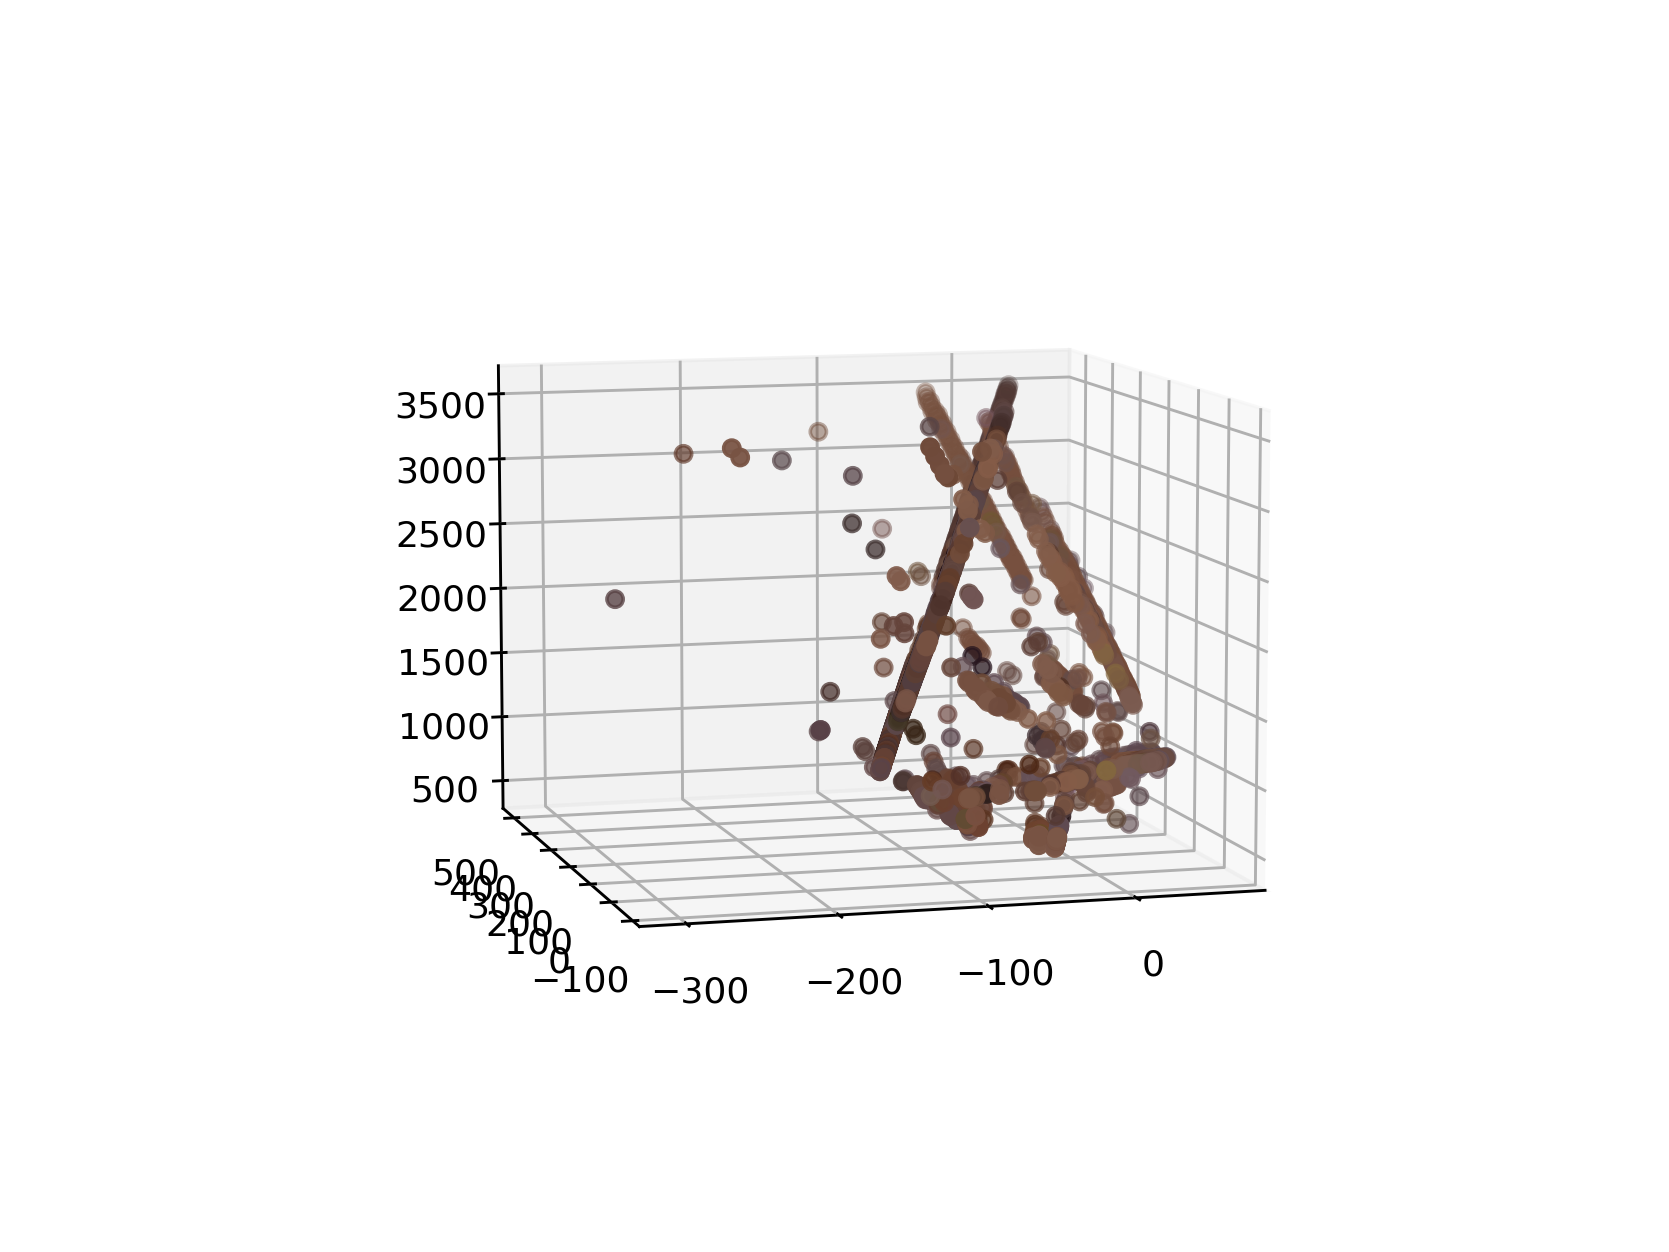

In [14]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P_array_filtered[:,0],P_array_filtered[:,1],P_array_filtered[:,2],c=p_color_array_filtered/255)

In [46]:
image_color[600,675:950]

array([[108,  67,  49],
       [108,  67,  49],
       [108,  67,  49],
       [108,  67,  49],
       [108,  67,  49],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [111,  70,  52],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [113,  71,  49],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [111,  69,  47],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [112,  69,  50],
       [109,  66,  47],
       [109,  66,  47],
       [109,  66,  47],
       [109,  66,  47],
       [109,  66

<IPython.core.display.Javascript object>


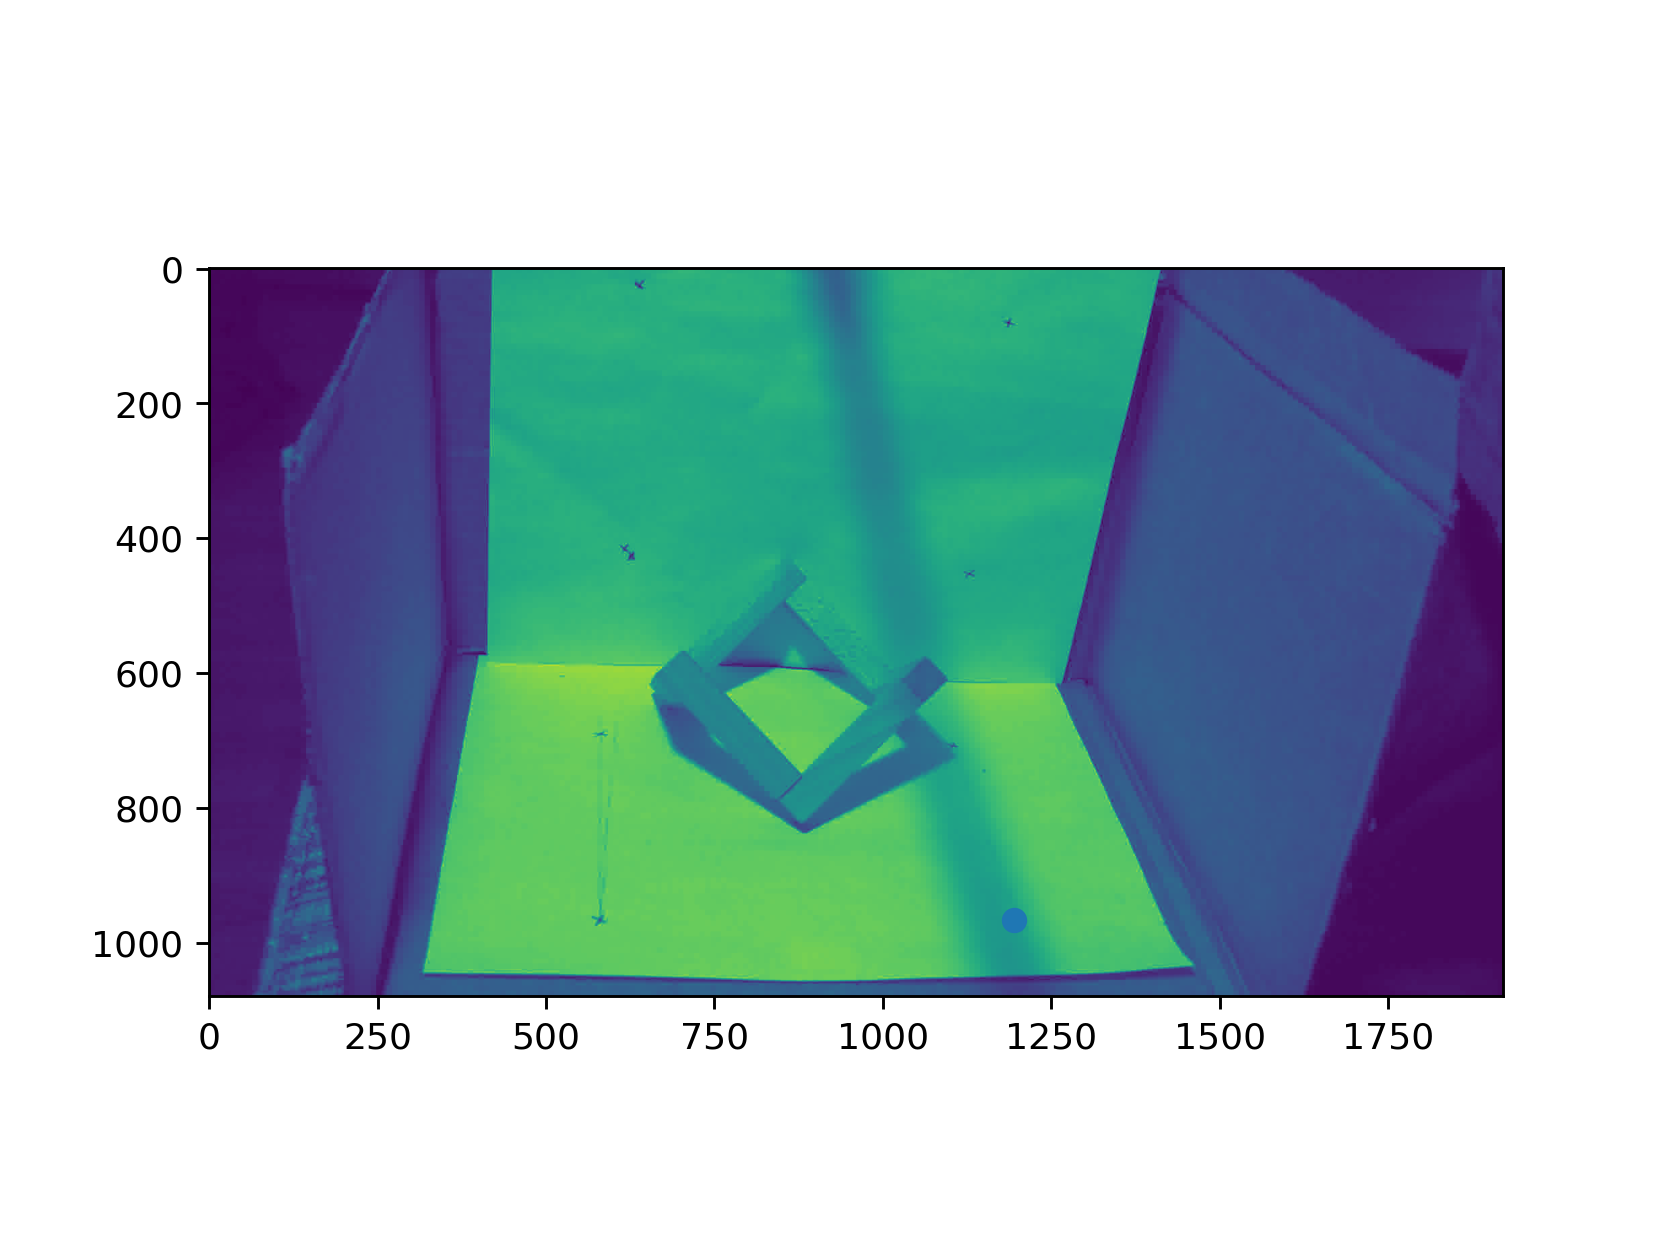

In [38]:
%matplotlib notebook
frame_no = 45
plt.figure()
plt.imshow(images[25+frame_no])
plt.scatter(pts_hor[frame_no][1,1],pts_hor[frame_no][1,0])
# plt.scatter(pts_ver[frame_no][:,1],pts_ver[frame_no][:,0])
# print(pts_ver[frame_no][70])

In [ ]:
P_array_filtered[P_array_filtered[:,2]>1500].shape

In [ ]:
P_array[np.linalg.norm(P_array, axis=1) < 4000 ].shape

In [ ]:
p_color_array_filtered / 255

In [ ]:
%matplotlib notebook
plt.imshow(images[60])

In [ ]:
I = images.copy()
I_max = np.max(I,0)
I_min = np.min(I,0)
I_shadow = (I_max + I_min) / 2
diff_image = np.zeros(I.shape)
shadow_time = np.zeros(I_shadow.shape)
for t in range(I.shape[0]) : 
    diff_image[t] = I[t] - I_shadow

In [ ]:
diff_image[20][100][475:550]

In [32]:
pts_hor[frame_no].shape

(7, 3)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


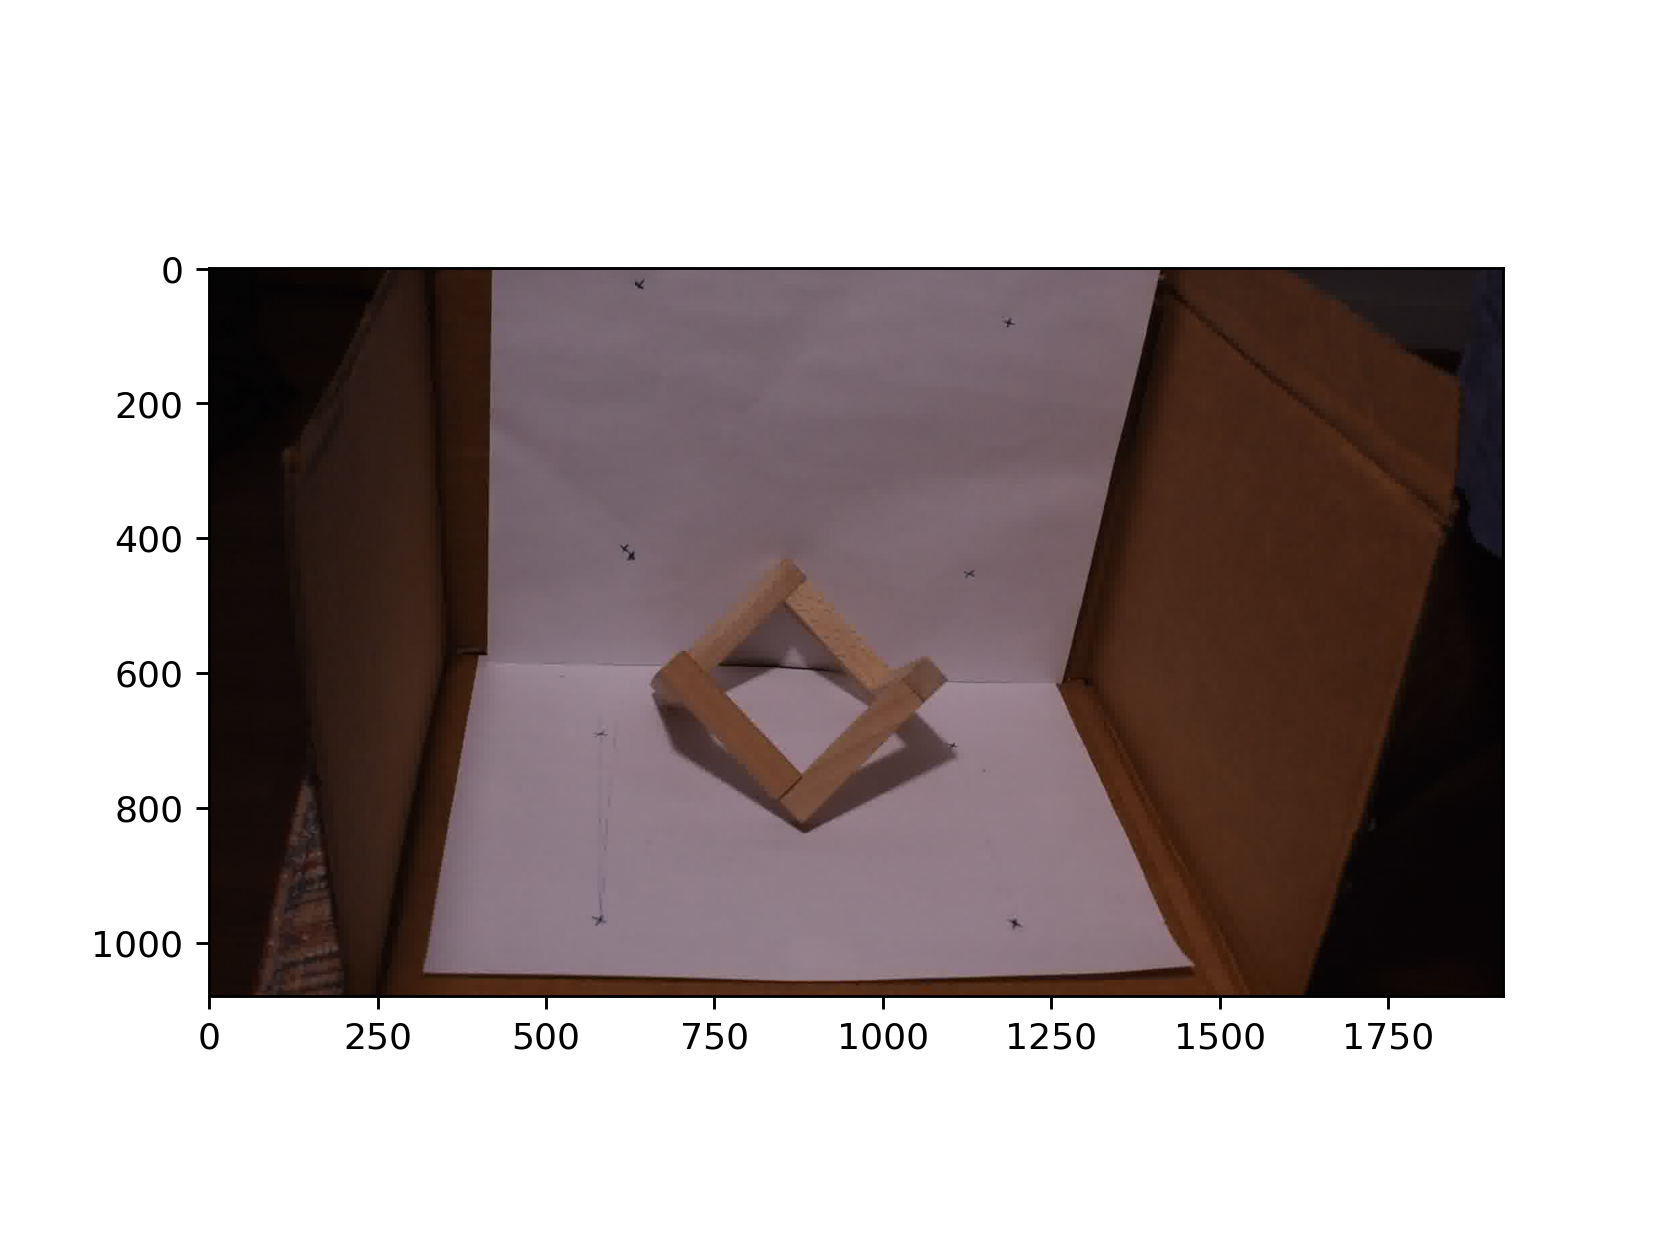

In [57]:
%matplotlib 
plt.imshow(image_color)

In [85]:
p_color_array_filtered.shape

(6934, 3)